In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Scoring model for B2B customers

A scoring model helps a company to determine the value of each customer to determine personalized acquision and marketing budgets on each customer or customer group. A classical approach is to classify customers into ABC classes or having a RFMR score model on it. The variables and weights which are used to classify a customer is not universal applicable and are normally defined differently from company-to-company. Common aspects, which are considered almost in each model, are

- Direct and indirect costs caused by customer
- Revenues gained individually by customer
- Time-related aspects of customer relationship

Based on the given data a simple RFM scoring is chosen to determine the individual score of each seller. Each dimension is calculated individually and afterwards summed up to the final score. The dimensions are calculated as following

- Recency: Latest order timestamp in dataset - latest order timestamp per seller
- Frequency: Sum of all order per seller
- Monetary: Sum of all order sales volumes per seller

In order to determine a score for the calculated values a percentile approach is chosen, which usually is set to 20% to get 5 customer segments in the end. In this project we will keep this rule of thumb for simplicity. In contrary to the original approach, the final RFM segment is not selected by "attaching" the individual scores to a class, like R=5 + F=4 + M=5 yields to class 545, it will be the mean chosen to simplify the score. 


In [14]:
def calc_recency(sellers, time):
    latest = max(pd.to_datetime(time).dt.date)
    start = min(pd.to_datetime(time).dt.date)
    recency = {}

    for seller, time in zip(sellers, pd.to_datetime(time).dt.date):
        if seller in recency:
            if time > recency[seller]:
                recency[seller] = time
            else:
                recency[seller] = recency[seller]
        else:
            recency[seller] = start

    for key in recency:
        recency[key] = (latest - recency[key]).days
    
    return recency

In [15]:
def calc_frequency(sellers):
    unique_sellers = sellers.unique()
    counts = []

    for seller in unique_sellers:
        counter = 0
        for row in sellers:
            if row == seller:
                counter += 1
            else:
                counter = counter
        counts.append(counter)

    return dict(zip(unique_sellers,counts))

In [16]:
def calc_monetary(orders, prices, sellers):
    frame = {'orders':orders, 'prices': prices, 'sellers': sellers}
    df = pd.DataFrame(frame)
    orders_revenues = df.groupby(by='orders').sum()
    df = df.merge(orders_revenues,on='orders')
    seller_revenues = df.groupby(by='sellers').sum().round(2)
    
    return  dict(zip(seller_revenues.index,seller_revenues.prices_y))

In [17]:
def create_rfm_df(sellers, orders, prices, time, rfm_range):
    labels = range(1, (rfm_range+1))
    scores = pd.DataFrame()
    scores['seller_id'] = sellers.unique()
    scores['revenues'] = scores.seller_id.map(calc_monetary(orders, prices, sellers))
    scores['count_orders'] = scores.seller_id.map(calc_frequency(sellers))
    scores['days_last_activity'] = scores.seller_id.map(calc_recency(sellers, time))
    scores['recency'] = pd.qcut(scores.days_last_activity,q=rfm_range, labels=labels)
    scores['frequency'] = pd.qcut(scores.count_orders,q=rfm_range, labels=labels)
    scores['monetary_ratio'] = pd.qcut(scores.revenues,q=rfm_range, labels=labels)
    scores['rfm_score'] = scores[['recency','frequency', 'monetary_ratio']].mean(axis=1).round(0)
    return scores

In [18]:
items = pd.read_csv('../data/raw/olist_order_items_dataset.csv', encoding='utf-8')
sellers = pd.read_csv('../data/raw/olist_sellers_dataset.csv', encoding='utf-8')
orders = pd.read_csv('../data/raw/olist_orders_dataset.csv', encoding='utf-8')

commerce = pd.merge(orders, items, on='order_id')
commerce = commerce.merge(sellers, on='seller_id')
rfm = create_rfm_df(sellers=commerce.seller_id, orders=commerce.order_id, prices=commerce.price, time=commerce.order_purchase_timestamp,rfm_range=5)

# Predictive Approach to score new B2B customers

In order to be able to score new B2B customers or even to know of a potential customer will be "profitable", a predictive approach based on existing B2B customers is chosen as tool to answer this question(s). The model will be set up by the calculated customer score as target variable and a set of seller attributes as predictors. As seller attributes will be chosen

- XXX
- XXX
- XXX
- XXX
- XXX

In [19]:
def merge_dfs(df_merge, merge_var, drop_vars, na):
    df = pd.merge(df_merge[0], df_merge[1], on=merge_var, how='left')
    df = df.drop(drop_vars, axis=1)
    df = df.dropna(subset=na)
    return df

In [20]:
def create_bool_dummies(df, var_list, rep_list):
    for var in var_list:
        df[var] = df[var].replace(to_replace=rep_list ,value= np.nan)
        df['bool_'+var] = ['False' if pd.isna(x) == True else 'True' for x in df[var]]
        df = df.drop(var, axis=1)
    return df

In [21]:
def repl_na_bool(df, var_list, value):
    for var in var_list:
        df[var] = df[var].replace(to_replace= [np.nan], value= value)
    return df

In [22]:
def create_days2conversion(df, start, end):
    df[start] = pd.to_datetime(df[start]).dt.date.astype('datetime64')
    df[end] = pd.to_datetime(df[end]).dt.date.astype('datetime64')
    df['days2conversion'] = (df[end] - df[start]).dt.days
    df = df.drop([start,end], axis=1)
    return df

In [23]:
def transform_cat_var(df, col_list):
    for col in col_list:
        df[col] = df[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

In [24]:
def train_classifier(df, feature_cols, target, test_size, cv, seed):
    X = df[feature_cols]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=seed)
    classifier = LogisticRegressionCV(cv=cv, random_state=seed)
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, X_test, y_test

In [25]:
def get_reports(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return plot_confusion_matrix(model, X_test, y_test) and print(classification_report(y_test, y_pred))

In [26]:
leads = pd.read_csv('../data/raw/olist_marketing_qualified_leads_dataset.csv', encoding='utf-8')
deals = pd.read_csv('../data/raw/olist_closed_deals_dataset.csv', encoding='utf-8')

marketing = merge_dfs(df_merge=[leads,deals], merge_var='mql_id', drop_vars=['sdr_id','sr_id'], na=['seller_id'])
marketing = merge_dfs(df_merge=[marketing, rfm], merge_var='seller_id', drop_vars=['mql_id', 'landing_page_id', 'revenues', 'count_orders', 'days_last_activity', 'recency',                            'frequency', 'monetary_ratio'], na=['rfm_score'])
marketing = create_bool_dummies(df=marketing, var_list=['declared_monthly_revenue', 'declared_product_catalog_size', 'average_stock'], rep_list=[0, 'unknown'])
marketing = repl_na_bool(df=marketing, var_list=['has_company','has_gtin'], value='false')
marketing = create_days2conversion(df= marketing, start='first_contact_date', end='won_date')
marketing = transform_cat_var(df=marketing, col_list=['origin', 'business_segment', 'lead_type', 'lead_behaviour_profile', 'has_company', 'has_gtin', 'business_type', 'bool_declared_monthly_revenue', 'bool_declared_product_catalog_size', 'bool_average_stock'])
marketing = marketing.set_index(marketing.seller_id).drop(labels=['seller_id'], axis=1)

In [27]:
feature_cols = ['origin', 'business_segment', 'lead_type', 'lead_behaviour_profile','has_company', 'has_gtin', 'business_type','bool_declared_monthly_revenue', 'bool_declared_product_catalog_size', 'bool_average_stock', 'days2conversion']

model, X_test, y_test = train_classifier(df=marketing, feature_cols=feature_cols, target='rfm_score', test_size=0.2, cv=10, seed=42 )

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         3
         2.0       0.42      1.00      0.59        32
         3.0       0.00      0.00      0.00        36
         4.0       0.00      0.00      0.00         5

    accuracy                           0.42        76
   macro avg       0.11      0.25      0.15        76
weighted avg       0.18      0.42      0.25        76



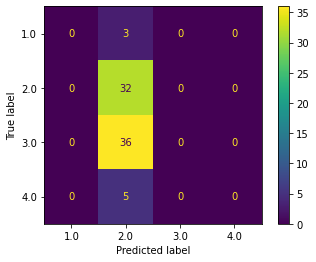

In [28]:
get_reports(model, X_test, y_test)

In [29]:
leads = pd.read_csv('../data/raw/olist_marketing_qualified_leads_dataset.csv', encoding='utf-8')
deals = pd.read_csv('../data/raw/olist_closed_deals_dataset.csv', encoding='utf-8')

marketing_2 = merge_dfs(df_merge=[leads,deals], merge_var='mql_id', drop_vars=['sdr_id','sr_id'], na=['seller_id'])

In [31]:
New = marketing_2[~marketing_2.seller_id.isin(marketing.index)]
New.to_csv('../data/raw/raw_new_customers.csv', encoding='utf-8', index=False)